# DEEP LEARNING OBJECT DETECTION FOR BALLISTIC EXPERIMENT ANALYSIS
MECE 687
Abraham Reyes Yanes

### Preparing the Environment

*Check you installed all the libraries need it. If you install the environment from the .txt file in the repository you should not have any problem.*

In [10]:
import cv2 
import numpy as np
import imutils
import time
import os
import pandas as pd
import numpy as np
import math
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns# ; sns.set()
from PIL import Image
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from IPython.display import clear_output
from datetime import datetime
import ipywidgets as widgets
from ipyfilechooser import FileChooser

### Checking Mask-RCNN

*Here, the prediction part is based in MASK-RCNN. Be sure to first clone that repository and install de dependencies.*

In [2]:
pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: c:\users\ur\anaconda3\envs\python-cvcourse\lib\site-packages\mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
import tensorflow as tf

Using TensorFlow backend.


In [5]:
class PredictionConfig(Config):
    NAME = "bullet_cfg"
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [6]:
tf.logging.set_verbosity(tf.logging.ERROR)
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model_path = 'trained_models/box_bullet_2nd.h5'
model.load_weights(model_path, by_name=True)

### Extracting Images from video

*In case your are re-running this part be sure to rename the previous main folder from past analysis ('Project_Bullet'), otherwise the action will prompt and error since will not be able to create the folder because one with the same name already exist.*

In [7]:
dirname_project = 'Project_Bullet'
os.mkdir(dirname_project)

In [16]:
dirname_frameoutputs = 'Project_Bullet/1_frame_outputs/'
os.mkdir(dirname_frameoutputs)

*Select here the video to analyze.*

In [17]:
fc = FileChooser('/Users/crahan/FC demo')
display(fc)

FileChooser(path='/Users/crahan/FC demo', filename='', show_hidden='False')

In [18]:
video=fc.selected

*The next cell extract all the frames in your video and save them in a new previous created folder named '1_frame_outputs'*

In [19]:
startTime = datetime.now()
camera = cv2.VideoCapture(video)
length = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
i=1
while True:
    res, frame = camera.read()
    if not res:
        False
        break
    cv2.imwrite(os.path.join(dirname_frameoutputs,'frame_%i.jpg'%i),frame)
    i=i+1
    if cv2.waitKey(110) & 0xff == 27:
        break 
print(datetime.now() - startTime)

0:00:08.462471


*Rename all the frames to the form 'frame_000000'*

In [20]:
for filename in os.listdir(dirname_frameoutputs):
    prefix, num = filename[:-4].split('_')
    num = num.zfill(6)
    new_filename = prefix + "_" + num + ".jpg"
    os.rename(os.path.join(dirname_frameoutputs, filename), os.path.join(dirname_frameoutputs, new_filename))

### Testing the model in one image

*Feel free to change the number of the picture 'frame_000020' to check how the model perform in your data.*

454 267 537 323


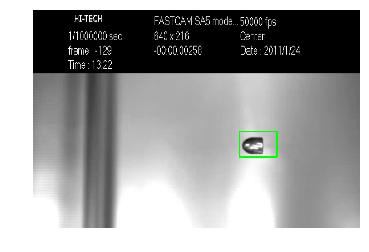

In [21]:
name = 'frame_000020.jpg'
path = os.path.join(dirname_frameoutputs,name)
image=plt.imread(path)
scaled_image = mold_image(image, cfg)
sample = expand_dims(scaled_image, 0)
yhat = model.detect(sample, verbose=0)[0]
box = yhat['rois']
y1, x1, y2, x2 = box[0]
width, height = x2 - x1, y2 - y1
cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),2)
plt.imshow(image)
plt.axis('off')
print(x1,y1,x2,y2)

### Predicting bullet location

*The next cell look for the bullet through all the frames (aprox 20 s per frame). 
It is advisable to look into the frames previously extracted (Project_Bullet/1_frames_output) and take note of the frame before impact to save time in the next cells. You can indicate the max_frame for the algorithm to look into by input the value in the next cell, in this way the algorithm will stop there and will not waste time in other frames. By default the value of max_frame is 1000 (never reachable) , and need to be keep it like that if you want the algorithm to look into all the frames.*

In [23]:
max_frame = 56

In [24]:
startTime = datetime.now()
path = dirname_frameoutputs
list_files=[f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))]
list_files= sorted(list_files)
num_files = len(list_files)
roi_matrix=np.zeros((num_files,4), dtype=int)
i=0
found=0
for filename in list_files:
    image=plt.imread(os.path.join(path, filename))
    scaled_image = mold_image(image, cfg)
    sample = expand_dims(scaled_image, 0)
    yhat = model.detect(sample, verbose=0)[0]
    box = yhat['rois']
    if not box.size >0:
        i=i+1
        clear_output()
        print("{} not found - {}".format(i,num_files))
        continue
    y1, x1, y2, x2 = box[0]
    width, height = x2 - x1, y2 - y1
    roi_matrix[i][0]= x1
    roi_matrix[i][1]= y1
    roi_matrix[i][2]= width
    roi_matrix[i][3]= height
    i=i+1
    clear_output()
    print("{} - {}".format(i,num_files))
    found=found+1
    if i == num_files:
        break
    if i == max_frame:
        break
np.savetxt(os.path.join(dirname_project,"roi_matrix_predicted.csv"),roi_matrix, delimiter=",")
clear_output()
print("{} found of {} frames".format(found,num_files))
time_detection = datetime.now() - startTime
print(datetime.now() - startTime)

54 found of 59 frames
0:15:19.470393


*We can see in the next cell what are the values predicted (X,Y,Width,Height) in each of the frames (rows). Where 0, means not bullet was found.*

In [25]:
display(roi_matrix)

array([[  0,   0,   0,   0],
       [707, 278,  13,  26],
       [685, 271,  35,  41],
       [685, 271,  35,  41],
       [656, 274,  64,  37],
       [639, 272,  79,  45],
       [639, 272,  79,  45],
       [606, 278,  91,  38],
       [598, 272,  78,  45],
       [597, 268,  76,  50],
       [572, 270,  83,  47],
       [553, 271,  82,  46],
       [553, 271,  82,  46],
       [531, 271,  83,  45],
       [510, 277,  81,  39],
       [512, 270,  80,  45],
       [494, 270,  78,  45],
       [475, 268,  75,  53],
       [477, 272,  74,  45],
       [454, 267,  83,  56],
       [437, 271,  73,  49],
       [437, 271,  73,  49],
       [405, 274,  83,  45],
       [394, 275,  70,  44],
       [393, 275,  71,  44],
       [369, 275,  85,  45],
       [347, 277,  76,  44],
       [347, 277,  76,  44],
       [326, 276,  92,  46],
       [310, 279,  75,  44],
       [310, 280,  76,  43],
       [286, 277,  75,  46],
       [264, 275,  79,  47],
       [264, 275,  79,  47],
       [237, 2

### Calculating new ROI's

*In the last cell the roi matrix is saved instead of predicting any time we need to adjust parameters, Therefore the next cell loads the saved csv matrix.*

In [27]:
roi_data = pd.read_csv(os.path.join(dirname_project, "roi_matrix_predicted.csv"),header=None,names=['X', 'Y','W','H']).astype(int)
roi_data.head()

,X,Y,W,H
0,0,0,0,0
1,707,278,13,26
2,685,271,35,41
3,685,271,35,41
4,656,274,64,37


*Calling an image to get shape.*

In [29]:
image = plt.imread(os.path.join(dirname_frameoutputs, "frame_000001.jpg"))
height,width,channels= image.shape

*For the image processing, the bigger the area of the Roi works better when trying to isolate the background from the foreground, then the rois are adjusted.*

In [30]:
startTime = datetime.now()
path = dirname_frameoutputs
list_files=[f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))]
num_files = len(list_files)
data_analysis = np.full((num_files,11),np.nan,dtype=float) # time,x,y,width,height,length,cx,angle,distance traveled, relative velocity per 2 frames,total velocity
i = 0
found=0
offset_x = 50
offset_y = 60
for filename in list_files:
    x_roi = roi_data['X'][i]
    y_roi = roi_data['Y'][i]
    w_roi = roi_data['W'][i]
    h_roi = roi_data['H'][i]
    if  roi_data['W'][i] == 0 :
        print("{} not found".format(i))
        i=i+1
        continue
    if w_roi < 60 :
        i=i+1
        continue
    if x_roi + int(w_roi/2) + 2*offset_x >= width:
        i=i+1
        continue
    if x_roi + int(w_roi/2) - offset_x <= 0:
        i=i+1
        continue
    data_analysis[i][1] = x_roi + (int(w_roi/2)) - offset_x
    data_analysis[i][2] = y_roi + (int(h_roi/2)) - offset_y
    data_analysis[i][3] = 2*offset_x
    data_analysis[i][4] = 2*offset_y
    clear_output()
    print("{} - {}".format(i,num_files))
    i=i+1 
    found=found+1
    if i == num_files:
        break
clear_output()
print("{} roi's of {} frames".format(found,num_files))
time_scaling_roi = datetime.now() - startTime
print(datetime.now() - startTime)

42 roi's of 59 frames
0:00:00.090759


### Creating ROI's

*The ROIs are created from the adjusted bounding box previously done.This rois will be need it when drawing the lines and annotations.*

In [31]:
dirname_roioutputs = 'Project_Bullet/2_roi_outputs'
os.mkdir(dirname_roioutputs)

In [32]:
startTime = datetime.now()
from_path = dirname_frameoutputs
dest_path = dirname_roioutputs
list_files=[f for f in os.listdir(from_path)if os.path.isfile(os.path.join(from_path, f))]
num_files = len(list_files)
i = 0
found=0
for filename in list_files:
    # reading image
    image = plt.imread(os.path.join(from_path, filename))
    prefix, num = filename[:-4].split('_')
    position = num
    position = int(re.sub("^0+","",position))
    _,x1,y1,w,h,_,_,_,_,_,_ = data_analysis[position - 1]
  
    if  np.isnan(w)  :
        print("{} not found".format(i))
        clear_output()
        i=i+1
        continue
    roi = image[int(y1):int(y1 + h),int(x1):int(x1 + w)]
    new_filename ="roi" + "_" + num + ".jpg"
    cv2.imwrite(os.path.join(dest_path ,new_filename),roi)
    clear_output()
    print("{} - {}".format(i,num_files))
    i=i+1 
    found=found+1
    if i == num_files:
        break
clear_output()
print("{} roi's of {} frames".format(found,num_files))
time_cropping_roi = datetime.now() - startTime
print(datetime.now() - startTime)

42 roi's of 59 frames
0:00:00.866680


### Filtering Images

In [33]:
dirname_maskoutputs = 'Project_Bullet/3_mask_outputs'
os.mkdir(dirname_maskoutputs)

In [34]:
dirname_contoursoutputs = 'Project_Bullet/4_contours_outputs'
os.mkdir(dirname_contoursoutputs)

In [35]:
dirname_drewoutputs = 'Project_Bullet/5_drew_outputs'
os.mkdir(dirname_drewoutputs)

#### Filters Parameters

*Some filters and morphological operations are applied in order to isolate the bullet from the background. The image processing is a challenging part when trying to develop adaptative algorithms that work with differents images. With the purpose of making this code flexible, the filters and morphological operations where parametrized. Varying the values of this parameters will affect/improve the outcome of the processing. In this way, the algorithm could be adapted to different videos without problems*

*The parameters are the following, the suggestion is start with the proposed values and check how the testing of the filters works. In case that improvement is need it, please read the documentation of the functions and vary the values at your convenience in the next cell*

In [120]:
### DONT CHANGE ANY VALUE IN THIS CELL, THIS ARE THE PREDIFINED VALUES
global n_gaussian,bilateral_diameter,bright_gamma,canny_sigma,n_gradient,n_dilating,f_closing,n_closing,it_erosion,n_erosion,f_smooth,n_smooth,low_thresh,high_thresh 
# Gaussian Blur
n_gaussian = 3
# Bilateral Blur
bilateral_diameter = 12
# Bright Correction
bright_gamma = 8                             
# Canny Detection
canny_sigma = 2.2
# Gradient 
n_gradient = 6
# Dilating
n_dilating = 3
# Clossing
f_closing = 12
n_closing = 10
# Erosion
it_erosion = 1
n_erosion = 1
# Smoothing
f_smooth = 10
n_smooth = 4
# Threshoold
low_thresh = 127
high_thresh = 255

*Widgets to vary the values, you can always re-set the predifined values*

In [126]:
caption = widgets.Label(value='Vary the values at your convenience, to set the values press set in the next cell')
ngaussian_updated = widgets.IntSlider(value=n_gaussian,min=0,max=15,step=2,description='N Gaussian:')
dbilateral_updated = widgets.IntSlider(value=bilateral_diameter,min=8,max=20,step=1,description='D Bilateral:')
gbright_updated = widgets.IntSlider(value=bright_gamma,min=6,max=20,step=1,description='G Brightness:')
scanny_updated = widgets.FloatSlider(value=canny_sigma,min=.5,max=3,step=.1,description='S Canny:')
ngradient_updated = widgets.IntSlider(value=n_gradient,min=2,max=10,step=1,description='N Gradient:')
ndilatation_updated = widgets.IntSlider(value=n_dilating,min=1,max=9,step=1,description='N Dilatation:')
fclosing_updated = widgets.IntSlider(value=f_closing,min=8,max=20,step=1,description='F Closing:')
nclosing_updated = widgets.IntSlider(value=n_closing,min=2,max=12,step=1,description='N Closing:')
iterosion_updated = widgets.IntSlider(value=it_erosion,min=1,max=6,step=1,description='IT Erosion:')
nerosion_updated = widgets.IntSlider(value=n_erosion,min=1,max=6,step=1,description='N Erosion:')
fsmooth_updated = widgets.IntSlider(value=f_smooth,min=6,max=16,step=1,description='F Smooth:')
nsmooth_updated = widgets.IntSlider(value=n_smooth,min=2,max=8,step=1,description='N Smooth:')
threshoold_updated = widgets.IntRangeSlider(value=[low_thresh,high_thresh],min=0,max=255,step=1,description='Threshoold:')
output = widgets.Output()
display(caption,ngaussian_updated,dbilateral_updated,gbright_updated,scanny_updated,ngradient_updated,ndilatation_updated,
        fclosing_updated,nclosing_updated,iterosion_updated,nerosion_updated,fsmooth_updated,nsmooth_updated,threshoold_updated)

Label(value='Vary the values at your convenience, to set the values press set in the next cell')

IntSlider(value=3, description='N Gaussian:', max=15, step=2)

IntSlider(value=12, description='D Bilateral:', max=20, min=8)

IntSlider(value=8, description='G Brightness:', max=20, min=6)

FloatSlider(value=2.2, description='S Canny:', max=3.0, min=0.5)

IntSlider(value=6, description='N Gradient:', max=10, min=2)

IntSlider(value=3, description='N Dilatation:', max=9, min=1)

IntSlider(value=12, description='F Closing:', max=20, min=8)

IntSlider(value=10, description='N Closing:', max=12, min=2)

IntSlider(value=1, description='IT Erosion:', max=6, min=1)

IntSlider(value=1, description='N Erosion:', max=6, min=1)

IntSlider(value=10, description='F Smooth:', max=16, min=6)

IntSlider(value=4, description='N Smooth:', max=8, min=2)

IntRangeSlider(value=(127, 255), description='Threshoold:', max=255)

In [122]:
def update_variables(b):
    global n_gaussian,bilateral_diameter,bright_gamma,canny_sigma,n_gradient,n_dilating,f_closing,n_closing,it_erosion,n_erosion,f_smooth,n_smooth,low_thresh,high_thresh 
    with output:
        n_gaussian = ngaussian_updated.value
        bilateral_diameter = dbilateral_updated.value
        bright_gamma = gbright_updated.value                       
        canny_sigma = scanny_updated.value
        n_gradient = ngradient_updated.value
        n_dilating = ndilatation_updated.value
        f_closing = fclosing_updated.value
        n_closing = nclosing_updated.value
        it_erosion = iterosion_updated.value
        n_erosion = nerosion_updated.value
        f_smooth = fsmooth_updated.value
        n_smooth = nsmooth_updated.value
        low_thresh = threshoold_updated.value[0]
        high_thresh = threshoold_updated.value[1]
        return n_gaussian,bilateral_diameter,bright_gamma,canny_sigma,n_gradient,n_dilating,f_closing,n_closing,it_erosion,n_erosion,f_smooth,n_smooth,low_thresh,high_thresh 

def restore_variables(b):
    global n_gaussian,bilateral_diameter,bright_gamma,canny_sigma,n_gradient,n_dilating,f_closing,n_closing,it_erosion,n_erosion,f_smooth,n_smooth,low_thresh,high_thresh 
    with output_2:
        n_gaussian = 3
        bilateral_diameter = 12
        bright_gamma = 8                             
        canny_sigma = 2.2
        n_gradient = 6
        n_dilating = 3
        f_closing = 12
        n_closing = 10
        it_erosion = 1
        n_erosion = 1
        f_smooth = 10
        n_smooth = 4
        low_thresh = 127
        high_thresh = 255
        return n_gaussian,bilateral_diameter,bright_gamma,canny_sigma,n_gradient,n_dilating,f_closing,n_closing,it_erosion,n_erosion,f_smooth,n_smooth,low_thresh,high_thresh 

button_update = widgets.Button(description='Update Variables')
output = widgets.Output()
button_reset = widgets.Button(description='Reset Variables')
output_2 = widgets.Output()
display(button_update,output,button_reset,output_2)
button_update.on_click(update_variables)
button_reset.on_click(restore_variables)

Button(description='Update Variables', style=ButtonStyle())

Output()

Button(description='Reset Variables', style=ButtonStyle())

Output()

#### Testing Filters

*Here, the values of the parameters are tested with 5 random ROI's, you can always go back, vary the values and Update them again to see how that changes the outcome. The purpose of this cell is to guarantee a good filter application in order to calculate an accurate contour from the Threshoold image.*

['roi_000022.jpg', 'roi_000039.jpg', 'roi_000044.jpg', 'roi_000016.jpg', 'roi_000050.jpg']


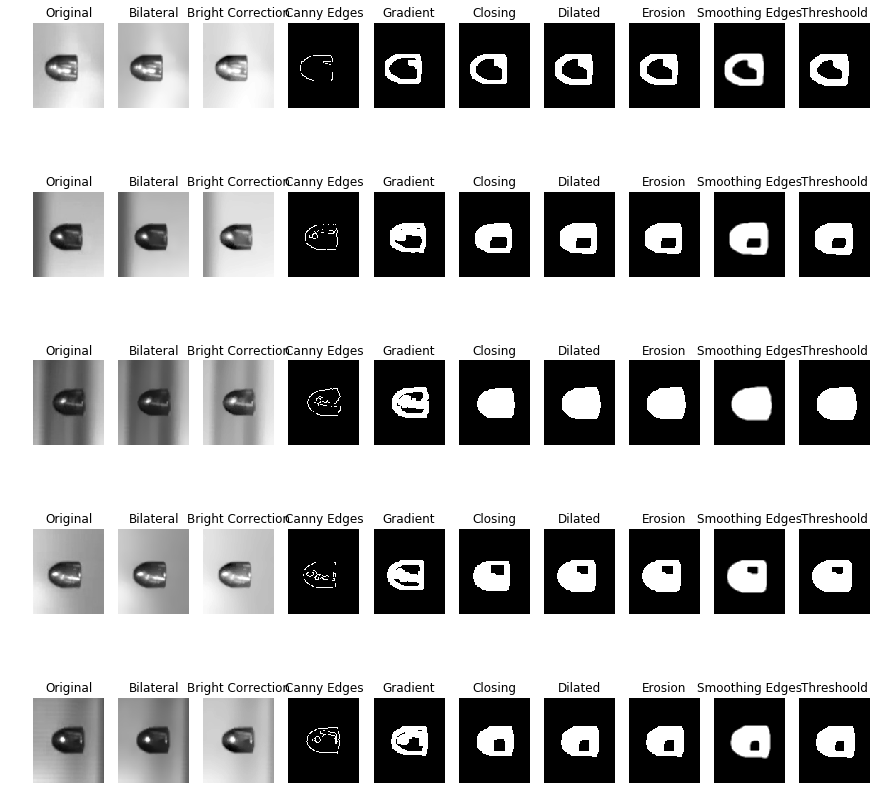

In [127]:
startTime = datetime.now()
from_path = dirname_roioutputs
list_files= [f for f in os.listdir(from_path)if os.path.isfile(os.path.join(from_path, f))]
random.shuffle(list_files)
list_files = list_files[0:5]
num_files = len(list_files)
fig, axs = plt.subplots(5,10,figsize=(15,15))
i = 0
for filename in list_files:
    
    image = cv2.imread(os.path.join(from_path,filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i, 0].imshow(image,cmap ='gray')
    axs[i, 0].set_title('Original')
    axs[i, 0].set_axis_off()
    
    bilateral_stdcolor = bilateral_diameter*2
    bilateral_stdspace = bilateral_diameter/2
    roi_blur = cv2.bilateralFilter(image,bilateral_diameter,bilateral_stdcolor,bilateral_stdspace)
    axs[i, 1].imshow(roi_blur,cmap ='gray')
    axs[i, 1].set_title('Bilateral')
    axs[i, 1].set_axis_off()

    roi_bright = np.power(roi_blur,1/bright_gamma)
    roi_corrected = np.array(roi_bright*255, dtype = np.uint8)
    roi_corrected = cv2.cvtColor(roi_corrected, cv2.COLOR_RGB2GRAY)
    axs[i, 2].imshow(roi_corrected,cmap ='gray')
    axs[i, 2].set_title('Bright Correction')
    axs[i, 2].set_axis_off()

    v = np.median(roi_corrected)
    lower = int(max(0, (1.0 - canny_sigma) * v))
    upper = int(min(255, (1.0 + canny_sigma) * v))
    edges = cv2.Canny(roi_corrected, lower, upper)
    axs[i, 3].imshow(edges,cmap ='gray')
    axs[i, 3].set_title('Canny Edges')
    axs[i, 3].set_axis_off()

    kernel_g = np.ones((n_gradient,n_gradient),np.uint8)
    gradient = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel_g)
    axs[i, 4].imshow(gradient,cmap ='gray')
    axs[i, 4].set_title('Gradient')
    axs[i, 4].set_axis_off()

    kernel_c = np.ones((n_closing,n_closing),np.uint8)*f_closing
    closing = cv2.morphologyEx(gradient, cv2.MORPH_CLOSE, kernel_c)
    axs[i, 5].imshow(closing,cmap ='gray')
    axs[i, 5].set_title('Closing')
    axs[i, 5].set_axis_off()

    kernel_d = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(n_dilating,n_dilating))   
    dilated = cv2.dilate(closing, kernel_d)
    axs[i, 6].imshow(dilated,cmap ='gray')
    axs[i, 6].set_title('Dilated')
    axs[i, 6].set_axis_off()

    kernel_e = np.ones((n_erosion,n_erosion),np.uint8)
    erosion = cv2.erode(dilated,kernel_e,iterations = it_erosion)
    axs[i, 7].imshow(erosion,cmap ='gray')
    axs[i, 7].set_title('Erosion')
    axs[i, 7].set_axis_off()

    kernel = np.ones((n_smooth,n_smooth),np.float32)/f_smooth
    smooth = cv2.filter2D(erosion,-1,kernel)
    axs[i, 8].imshow(smooth,cmap ='gray')
    axs[i, 8].set_title('Smoothing Edges')
    axs[i, 8].set_axis_off()

    ret,roi_thresh = cv2.threshold(smooth,low_thresh,high_thresh,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    axs[i, 9].imshow(roi_thresh,cmap ='gray')
    axs[i, 9].set_title('Threshoold')
    axs[i, 9].set_axis_off()

    i=i+1   
    if i == num_files +1:
        break
for ax in axs.flat:
    ax.label_outer()

print(list_files)
plt.show()

*Once the parameters are set, please proceed to apply these filters and operations to all the Roi's. Also, the centroid, area, angle and distance travelled is calculated in the next cell.*

In [128]:
startTime = datetime.now()
from_path = dirname_roioutputs
mask_path = dirname_maskoutputs
contour_path = dirname_contoursoutputs
drew_path = dirname_drewoutputs
list_files=[f for f in os.listdir(from_path)if os.path.isfile(os.path.join(from_path, f))]
num_files = len(list_files)
i = 0
for filename in list_files:
    image = cv2.imread(os.path.join(from_path, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
###APPLYING FILTERs
    #roi_blur = cv2.GaussianBlur(image,(n_gaussian,n_gaussian),0,0)
    bilateral_stdcolor = bilateral_diameter*2
    bilateral_stdspace = bilateral_diameter/2
    roi_blur = cv2.bilateralFilter(image,bilateral_diameter,bilateral_stdcolor,bilateral_stdspace)
    # APPLYING BRIGHT CORRECTION
    roi_bright = np.power(roi_blur,1/bright_gamma)
    roi_corrected = np.array(roi_bright* 255, dtype = np.uint8)
    roi_corrected = cv2.cvtColor(roi_corrected, cv2.COLOR_RGB2GRAY)
    # Canny edges
    v = np.median(roi_corrected)
    lower = int(max(0, (1.0 - canny_sigma) * v))
    upper = int(min(255, (1.0 + canny_sigma) * v))
    edges = cv2.Canny(roi_corrected, lower, upper)
    # Gradient to close contour
    kernel_g = np.ones((n_gradient,n_gradient),np.uint8)
    gradient = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel_g)
    # Clossing to remove internal noise
    kernel_c = np.ones((n_closing,n_closing),np.uint8)*f_closing
    closing = cv2.morphologyEx(gradient, cv2.MORPH_CLOSE, kernel_c)
    # Dilating the edges to strenght edges
    kernel_d = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(n_dilating,n_dilating))
    dilated = cv2.dilate(closing, kernel_d)  
    #Applying Erosion for smoothing edges
    kernel_e = np.ones((n_erosion,n_erosion),np.uint8)
    erosion = cv2.erode(dilated,kernel_e,iterations = it_erosion)
    #APPLYING SMOOTHING
    kernel = np.ones((n_smooth,n_smooth),np.float32)/f_smooth
    smooth = cv2.filter2D(erosion,-1,kernel)
    # Applying Threshold
    ret,roi_thresh = cv2.threshold(smooth,low_thresh,high_thresh,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Saving File
    prefix, num = filename[:-4].split('_')
    position = num
    position = int(re.sub("^0+","",position))
    new_filename_mask ="mask" + "_" + num + ".jpg"
    cv2.imwrite(os.path.join(mask_path,new_filename_mask),roi_thresh)
### FINDING CONTOURS
    contour_img = image.copy()
    items = cv2.findContours(roi_thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = items[0] if len(items) == 2 else items[1]
    cv2.drawContours(contour_img,contours,-1, (0, 255, 0), 2) 
    new_filename_contour ="contours" + "_" + num + ".jpg"
    cv2.imwrite(os.path.join(contour_path,new_filename_contour),contour_img)
    ### GETTING AREA
    c = max(contours, key=cv2.contourArea)
    M = cv2.moments(c)
    area = cv2.contourArea(c)
    #data_analysis[position - 1][4]= area
### GETTING CENTROID and Bounding Box
    # determine the most extreme points along the contour
    line_img = image.copy()
    extLeft = tuple(c[c[:,:, 0].argmin()][0])
    extRight = tuple(c[c[:,:, 0].argmax()][0])
    extTop = tuple(c[c[:,:, 1].argmin()][0])
    extBot = tuple(c[c[:,:, 1].argmax()][0])
    # where extLeft is the farthest point at the left(tip of the bullet)
    x_left = extLeft[0]
    x_right = extRight[0]
    y_bottom = extBot[1]
    y_top = extTop[1]
    cv2.rectangle(line_img,(x_left,y_bottom),(x_right,y_top),(0,255,0),2)
### GETTING LENGTH OF BULLET
    length  = abs(x_left - x_right)
    data_analysis[position - 1][5]= length
    #Calculating centroid
    cX = M["m10"] / M["m00"]
    cY = M["m01"] / M["m00"]
    centroid= (int(cX),int(cY))
    cv2.circle(line_img,centroid,1,(255,165,0),3) 
    #Saving centroid
    _,x1, y1, width, height,_,_,_,_,_,_ = data_analysis[position - 1]
    centroid_X_value = cX + x_roi
    data_analysis[position - 1][6]= centroid_X_value + x1
### DRAWING BOUNDING BOX AND LINES
    #Extending driven line
    m= ((line_img.shape[0]-extLeft[1])-(line_img.shape[0]-cY))/(extLeft[0]-cX)
    d= ((line_img.shape[0]-extLeft[1])+(-m*extLeft[0]))
    x_value=10
    dline_1 = (x_value,line_img.shape[0]-int((m*10)+d))
    dline_2 = (line_img.shape[1]-x_value,line_img.shape[0]-int((m*(line_img.shape[1]-10))+d))
    cv2.line(line_img,dline_1,dline_2,(255,0,0),1)                                     ### Pitch line
    cv2.line(line_img,(x_value,int(cY)),(line_img.shape[1]-x_value,int(cY)),(0,0,0),1) ### Reference line
    cv2.circle(line_img,extLeft,1,(255,165,0),3)
    new_filename_contour ="lines" + "_" + num + ".jpg"
    cv2.imwrite(os.path.join(drew_path,new_filename_contour),line_img)
### ANGLE AND DISTANCE TRAVELED
    ###Horizontal line
    dx_h= (extLeft[0]-int(cX))
    dy_h= int(cY)-int(cY)
    dist_hor = math.sqrt(math.pow(dx_h, 2)+math.pow(dy_h, 2))
    ###Pitch line
    dx_p=(extLeft[0]-int(cX))
    dy_p=((line_img.shape[0]-extLeft[1])-(line_img.shape[0]-cY))
    dist_pitch = math.sqrt(math.pow(dx_p, 2)+math.pow(dy_p, 2))
    ### Angle Calculation
    quotient = dist_hor/dist_pitch
    angle=np.arccos(quotient)
    angle = math.degrees(angle)
    data_analysis[position - 1][7] = angle
    ### Distance Travelled Calculation
    if i != 0 :
        data_analysis[position - 1][8] = abs(data_analysis[position - 2][6] - data_analysis[position - 1][6])      
    #Finishing
    clear_output()
    print("{} - {}".format(i,num_files))
    i=i+1 
    if i == num_files:
        break
clear_output()
plt.show()
print("{} of {} roi's".format(i,num_files))
time_filters_operations = datetime.now() - startTime
print(datetime.now() - startTime)

42 of 42 roi's
0:00:01.316176


#### Relative Velocity

*Calculation of relative velocity. Here is necessary to define the fps of the video and the length of the bullet in the video.Some common values are shown for reference:*

fps = 50000 or 75000 or 2e6

bullet_lenght = .02683 for 9mm bullet, .056 for AK47 bullet

In [129]:
fps=50000
bullet_length=.02863

In [130]:
startTime = datetime.now()
i = 0
for rows in data_analysis:
    #Pixel -m dimension
    average_length_pixels= np.nanmean(data_analysis[:,5])         #pixels
    pixel_m = bullet_length/average_length_pixels
    traveled_frames = 2
    traveled_seconds = traveled_frames/fps
    traveled_pixels =np.nansum(data_analysis[i,8])
    if i > 0 :
        data_analysis[i][0] = i/fps
    if traveled_pixels > 10 :
        relative_velocity = (pixel_m* traveled_pixels)/ traveled_seconds
        data_analysis[i][9] = relative_velocity
    #Finishing
    i=i+1 
time_relative_velocity = datetime.now() - startTime
print(datetime.now() - startTime)

0:00:00.004988


#### Total Relative Velocity

In [131]:
startTime = datetime.now()
traveled_pixels= np.nansum(data_analysis[:,8])
traveled_frames= data_analysis[:,7].size - np.count_nonzero(np.isnan(data_analysis[:,8]))
traveled_seconds= traveled_frames/fps
total_relative_velocity = (pixel_m * traveled_pixels) / traveled_seconds
data_analysis[0][10] = total_relative_velocity

print('Frames travelled = {0} '.format(traveled_frames) + 'frames')
print('Seconds travelled = {0} '.format(traveled_seconds) + 'seconds')
print('Total Relative Velocity = {0} '.format(total_relative_velocity) + 'm/s')
time_total_relative_velocity = datetime.now() - startTime
print(datetime.now() - startTime)

Frames travelled = 41 frames
Seconds travelled = 0.00082 seconds
Total Relative Velocity = 364.1543516850725 m/s
0:00:00


In [132]:
np.savetxt(os.path.join(dirname_project,"data_analysis.csv"),data_analysis, delimiter=",",header='TIME,X,Y,WIDTH,HEIGHT,LENGHT,CX,ANGLE,TRAVELED DISTANCE,RELATIVE VELOCITY,TOTAL RELATIVE VELOCITY')

#### Exporting to final frame

In [133]:
dirname_annotated = 'Project_Bullet/6_annotated'
os.mkdir(dirname_annotated)

In [134]:
startTime = datetime.now()
from_path = dirname_frameoutputs
drew_path =  dirname_drewoutputs
dest_path = dirname_annotated
list_files=[f for f in os.listdir(from_path)if os.path.isfile(os.path.join(from_path, f))]
num_files = len(list_files)
### Defining values for letters
font= cv2.FONT_HERSHEY_SIMPLEX
i = 0
for filename in list_files:
    # reading image
    image = plt.imread(os.path.join(from_path, filename))
    image = image.copy()
    prefix, num = filename[:-4].split('_')
    position = num
    position = int(re.sub("^0+","",position))
    new_filename ="annotated" + "_" + num + ".jpg"
    if np.isnan(data_analysis[position - 1,4]) :
        cv2.imwrite(os.path.join(dest_path ,new_filename),image)
        i=i+1 
        continue
    t,x1,y1,w,h,l,cx,an,dt,rv,_ = data_analysis[position - 1] # x,y,width,height,length,cx,angle,distance traveled, relative velocity per 2 frames
    roi = plt.imread(os.path.join(drew_path, 'lines_'+ num+'.jpg'))
    image[int(y1):int(y1 + h),int(x1):int(x1 + w)] = roi
    try:
        cv2.putText(image,'Angle : {0:.2f}'.format(an) +' Degrees',(20,240),font,.5,(0, 0, 255),1)
        cv2.putText(image,'Rv: {0:.2f}'.format(rv) + ' m/s',(20,270),font,.5,(0, 0, 255),1)
    except Exception:
        pass
    cv2.putText(image,'Total Relative velocity : {0:.2f}'.format(data_analysis[0,10]) + ' m/s',(180,400),font,.6,(255, 0, 0),1)
    cv2.imwrite(os.path.join(dest_path ,new_filename),image)
    i=i+1
    if i == num_files:
        break
time_final_frame = datetime.now() - startTime
print(datetime.now() - startTime)

0:00:01.606539


#### Saving a New Video

In [135]:
image = plt.imread(os.path.join(dirname_frameoutputs, "frame_000001.jpg"))
height,width,channels= image.shape

In [136]:
startTime = datetime.now()
from_path = dirname_annotated
dest_path = dirname_project
list_files=[f for f in os.listdir(from_path)if os.path.isfile(os.path.join(from_path, f))]
list_files=sorted(list_files)
num_files = len(list_files)
fps = 9
filename= 'annotated_video.avi'
writer = cv2.VideoWriter(os.path.join(dest_path, filename),cv2.VideoWriter_fourcc(*"DIVX"),fps,(width, height))
i = 0
for filename in list_files:
    image = plt.imread(os.path.join(from_path, filename))
    time.sleep(1/fps)
    writer.write(image) 
    i=i+1
    if i == num_files:
        break
writer.release()
time_exporting = datetime.now() - startTime
print(datetime.now() - startTime)

0:00:08.693676


#### DATA ANALYSIS

In [137]:
data_analysis_table = pd.read_csv(os.path.join(dirname_project,'data_analysis.csv'))
data_analysis_table.head()

,# TIME,X,Y,WIDTH,HEIGHT,LENGHT,CX,ANGLE,TRAVELED DISTANCE,RELATIVE VELOCITY,TOTAL RELATIVE VELOCITY
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,364.154352
1,0.00002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


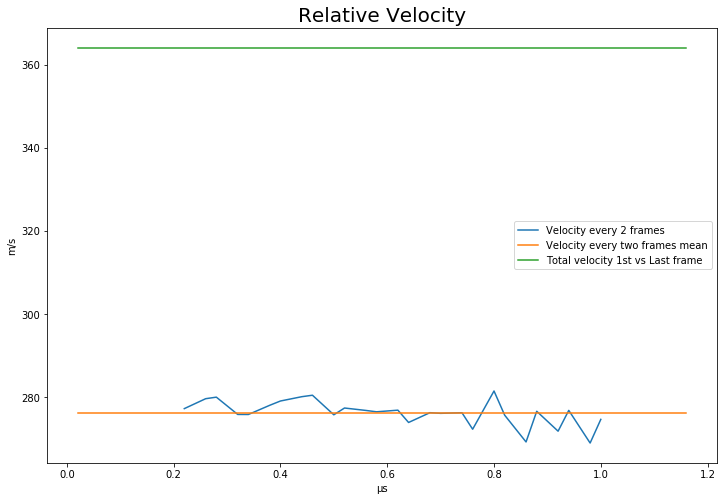

In [138]:
fig = plt.figure(figsize=(12,8))
sns.lineplot(data_analysis_table['# TIME']*1000,data_analysis_table['RELATIVE VELOCITY'])
sns.lineplot(data_analysis_table['# TIME']*1000,data_analysis_table['RELATIVE VELOCITY'].mean())
sns.lineplot(data_analysis_table['# TIME']*1000,data_analysis_table['TOTAL RELATIVE VELOCITY'][0])
plt.legend(['Velocity every 2 frames','Velocity every two frames mean','Total velocity 1st vs Last frame'])
plt.xlabel('μs')
plt.ylabel('m/s')
plt.title('Relative Velocity',fontsize = 20)
plt.savefig(os.path.join(dirname_project,'Relative Velocity.png'))

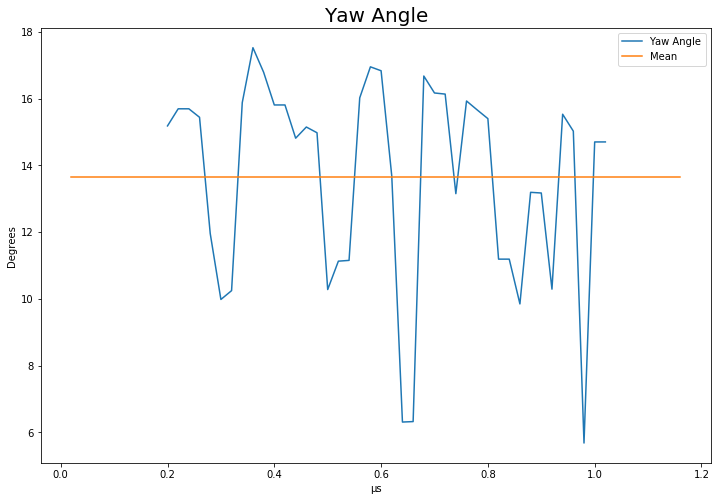

In [139]:
fig = plt.figure(figsize=(12,8))
sns.lineplot(data_analysis_table['# TIME']*1000,data_analysis_table['ANGLE'])
sns.lineplot(data_analysis_table['# TIME']*1000,data_analysis_table['ANGLE'].mean())
plt.legend(['Yaw Angle','Mean'])
plt.xlabel('μs')
plt.ylabel('Degrees')
plt.title('Yaw Angle',fontsize = 20)
plt.savefig(os.path.join(dirname_project,'Yaw Angle.png'))

In [140]:
timing_labels =['Detection time','ROI calculation','ROI cropping','Image processing','Calculations','Exporting']
timing_values =[time_detection.total_seconds(),time_scaling_roi.total_seconds(),time_cropping_roi.total_seconds(),time_filters_operations.total_seconds(),time_relative_velocity.total_seconds()+time_total_relative_velocity.total_seconds(),time_final_frame.total_seconds()]
times_elapsed = {'Step':timing_labels,'Seconds':timing_values}
times_dataframe = pd.DataFrame(times_elapsed)
times_dataframe.to_csv(os.path.join(dirname_project,'timing_analysis.csv'),index=False)
times_dataframe.head()

,Step,Seconds
0,Detection time,919.470393
1,ROI calculation,0.090759
2,ROI cropping,0.866680
3,Image processing,1.316176
4,Calculations,0.004988
